In [6]:
import numpy as np

from skimage import data
from skimage.color import rgb2gray
from skimage.filters import sobel_h, sobel_v, gaussian
from skimage.feature import match_descriptors
from skimage.exposure import rescale_intensity
from skimage import transform
from sklearn import preprocessing

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sb


from skimage.draw import (line, circle_perimeter)
from enum import Enum

%matplotlib inline 


### DAISY implementation

implementation of DAISY descriptors calculation for the whole image

In [2]:
class NormType(Enum):
    NRM_NONE = 1
    NRM_PARTIAL = 2 
    NRM_FULL = 3
    NRM_SIFT_STYLE = 4

# Computes a Gradient Orientation Map on derivative axis
# with angle tetha
def gradient_orientation(image, tetha):
    # Steering filter - combination of X and Y derivatives 
    # to det a derivative on a specific angle
    d_hor = sobel_h(image)
    d_ver = sobel_v(image)
    derivative = d_hor * np.cos(tetha) + d_ver * np.sin(tetha)
    # Operator max(d, 0) levaes only positive derivative
    derivative = derivative.clip(min=0)
    return derivative

# Compute GOs for a number of directions
def compute_global_orientation_maps(image, H):
    tetha_step = 2 * np.pi / H
    result = []
    for k in range(0, H):
        tetha = tetha_step * k
        result.append(gradient_orientation(image, tetha))
    return result

# Convolves orientation maps with Gaussian
# kernels with specified standard deviations
def convolve_orientation_maps(gos, sigmas):
    result = []
    for sigma in sigmas:
        conv = []
        for go in gos:
            conv.append(gaussian(go, sigma))
        result.append(conv)
    return result

# Calculation of a single DAISY descriptor for a given point of an image
def daisy(image, center, R, Q, T, H, sigmas, norm=NormType.NRM_NONE):
    
    # Setting steps in angle and radius
    tetha_step = 2 * np.pi / T
    radius_step = float(R) / Q
    # Calculating total number of entries in a descriptor
    Ds = (Q*T+1)*H
    descriptor = np.zeros((1, Ds))
    
    # Copy of image for visualization
    visualize = np.copy(image)
    
    # Compute GOs
    gradient_orientations = compute_global_orientation_maps(image, H)
    # Convolve GOs with Gaussian kernels to get COMs
    conv_orient_maps = convolve_orientation_maps(gradient_orientations, sigmas)
    
    # Sampling vectors from COMs at DAISY points
    # Center point
    h = sample_h_vector(center[0], center[1], conv_orient_maps[0], visualize, sigmas[0])
    descriptor[0, 0:H] = h
    # Sample the rest of the points in DAISY pattern
    for i in range(0, Q):
        r = (i+1) * radius_step
        maps = conv_orient_maps[i]
        for j in range(0, T):
            tetha = j * tetha_step
            x = int(center[0] + r * np.cos(tetha))
            y = int(center[1] + r * np.sin(tetha))
            
            h = sample_h_vector(x, y, maps, visualize, sigmas[i+1])
            # Normalization for partial norm type
            if norm == NormType.NRM_PARTIAL:
                h = preprocessing.normalize(h.reshape((1, -1)), norm='l2')

            idx_start = ((i)*T+j)*H+H
            idx_end = ((i)*T+j)*H+2*H
            descriptor[0, idx_start:idx_end] = h
    
    # Normalization for full norm type
    if norm == NormType.NRM_FULL:
        descriptor = preprocessing.normalize(descriptor.reshape((1, -1)), norm='l2')
    # Normalization for SIFT-style norm
    if norm == NormType.NRM_SIFT_STYLE:
        descriptor = preprocessing.normalize(descriptor.reshape((1, -1)), norm='l2')
        descriptor = descriptor.clip(max=0.154)
        descriptor /= descriptor.sum()
        
    return descriptor, visualize, gradient_orientations, conv_orient_maps

# Samples the single h vector at point 
def sample_h_vector(x, y, maps, visualize, sigma):
    # Sampling the vector
    h = np.zeros(H)
    for k in range(0, H):
        h[k] = maps[k][x, y]
    # Visualize the point
    draw_circle(visualize, x, y, sigma)
    draw_lines(visualize, x, y, sigma, H)
    return h

#### Utility functions
Functions for data visualization

In [3]:
# Draws a circle
def draw_circle(image, x, y, radius):
    rr, cc = circle_perimeter(x, y, radius)
    image[rr, cc] = 255

# Draws a set of evenly arranged lines from center
def draw_lines(image, x, y, radius, n):
    tetha_step = 2 * np.pi / n
    for i in range(0, n):
        tetha = i * tetha_step
        line_len = int(radius * 0.7)
        x1 = int(x + line_len * np.sin(tetha))
        j1 = int(y + line_len * np.cos(tetha))
        rr, cc = line(x, y, x1, j1)
        image[rr, cc] = 255
    
# Shows an image
def imgshow(image, title='', cmap=plt.cm.gray):
    fig, ax = plt.subplots()
    ax.imshow(image, cmap=cmap)
    ax.set_title(title)
    plt.show()

# Shows a set of images in a grid 
def show_maps(maps, title=''):
    grid_i = 2
    grid_j = int(np.ceil(len(maps) / 2))
    fig, ax = plt.subplots(grid_i, grid_j)
    fig.suptitle(title)
    for i in range(0, grid_i):
        for j in range(0, grid_j):
            idx = i*grid_j+j
            if(idx >= len(maps)):
                break
            ax[i, j].set_title(idx)
            ax[i, j].imshow(maps[idx], cmap = plt.cm.plasma)
    plt.tight_layout()

# Simple XY 2d plot
def plot_xy(x, y, title='', xlabel='', ylabel=''):
    fig, ax = plt.subplots()
    ax.plot(x, y)
    ax.grid()
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    plt.tight_layout()
    plt.show()

## Test data preparation
We use a 128 * 128 sample of a contrast grayscale image from skimage.data

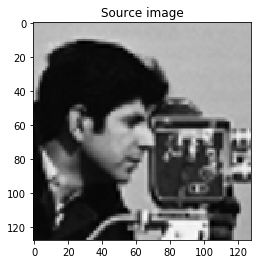

Image size:(128, 128)


In [7]:
img_src = data.camera()

center = [128, 256]
size = [128, 128]

image = img_src[int(center[0]-size[0] / 2):int(center[0]+size[0] / 2), 
           int(center[1]-size[1] / 2):int(center[1]+size[1] / 2)]
imgshow(image, 'Source image')
print(f'Image size:{image.shape}')

## Testing section 
Here is the list of modifiable parameters:
* Maximum radius $R$
* Number of rings $Q$
* Number of points per ring $T$
* Number of histograms per point $H$
* Gaussian filter standard deviations $\sigma$ for each ring
* Normalization type

**Notice that big sigma values or radius may result in index out of bounds exception!** 

In [9]:
R = 30
Q = 2
T = 8
H = 8
SIGMAS = [5, 10, 25]
NORM = NormType.NRM_SIFT_STYLE

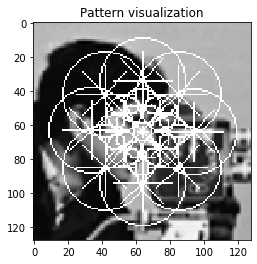

In [10]:
# Computing one descriptor at the center of the image
x, y = image.shape
point = [int(x/2), int(y/2)]

descriptor, visualize, gradient_orientations, coms = daisy(image, point, R, Q, T, H, SIGMAS, NORM)
imgshow(visualize, title='Pattern visualization')